# Week 2: Principal Component Analysis

**Student Name 1, Student Name 2** 

In this workshop, we will work through a set of problems on dimensionality reduction -- a cannonical form of unsupervised learning. Within the machine learning pipeline, dimensionality reduction is an important tool, which can used in EDA to understand patterns in the data, feature engineering to create a low-dimensional representation of the inputs, and/or in the final phase when you are presenting and visualizing your solution.

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 

## Outline

1. [Problem Definition and Setup](#setup)

2. [Principal Component Analysis](#pca)

    a. [Examining the Basis Vectors and Scores](#basis)

    b. [Selecting the Number of Components](#nocomponents)

    c. [Other Digits](#other)

3. [Kernel PCA](#kpca)

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, lets load in some packages to get us started. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data

Our dataset will be the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which we will download from sklearn. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and focus on the images themselves. Specifically, we will use dimensionality reduction to explore the images and underlying patterns and find a low-dimensional representation.

First, load the data:

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',parser = 'auto')
X = mnist.data
y = mnist.target

### 🚩 Exercise 1 (CORE)

What is stored in `X` and `y` in the command above? What is the shape/datatype etc if an array?


In [11]:
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(70000, 784)
(70000,)


X stored a dateframe, y store a series. the shape of X is (70000,784), the shape of y is (70000,).

Now, let's create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [4]:
digits_dict = {}
X_= X.values
count = 0

for label in y:
  if label in digits_dict:
    digits_dict[label] += [X_[count]]
  else:
    digits_dict[label] = [X_[count]]
  count += 1

Next let's visualize some of the images. We will start by picking a label and plotting a few images from within the dictionary. Note that each image contains a total of 784 pixels (28 by 28) and we will need to `reshape` the image to plot with `imshow(...,cmap='gray_r')`. Try also changing the label to view different digits.

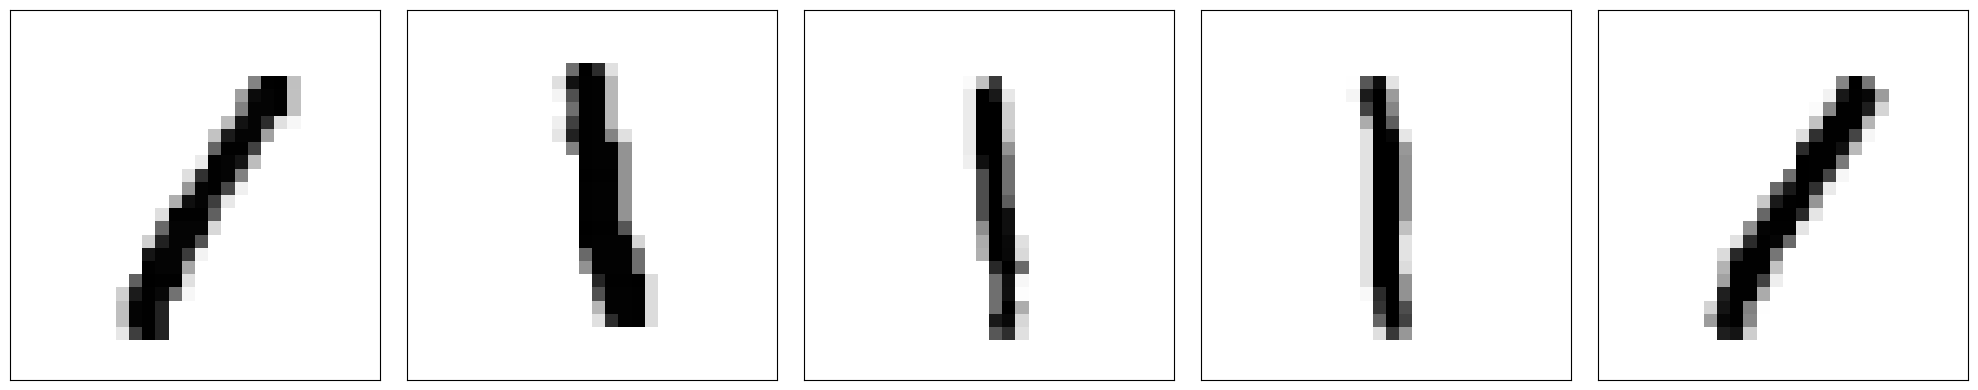

In [4]:
mylabel = '1'
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4))
for j in range(n_images_per_label):
    ax_number = 1 + j
    ax = fig.add_subplot(1, n_images_per_label, ax_number)
    ax.imshow(digits_dict[mylabel][j].reshape((28,28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 2 (EXTRA)

Edit the code above to plot a few images for multiple labels.

<br>
<details><summary><b><u>Hint</b></u></summary>

Create a vector of labels and add additional for loop in the code above.
</details>

In [ ]:
# Code for your answer here!

### 🚩 Exercise 3 (CORE)

Now focus on the 3s only and create a data matrix called `X_threes`. Define also `N` (# datapoints) and `D` (# features).

What are the features in this problem? How many features and data points are there? 

In [10]:
X_threes=np.array(digits_dict['3'])
N = len(X_three)
D = X_three.shape[1]
print(N,D)
print(X_three.shape)

7141 784
(7141, 784)


There are 7141 datapoints and 748 features. features is pixel intensities.

### 🚩 Exercise 4 (CORE)

Now compute and plot the mean image of three.

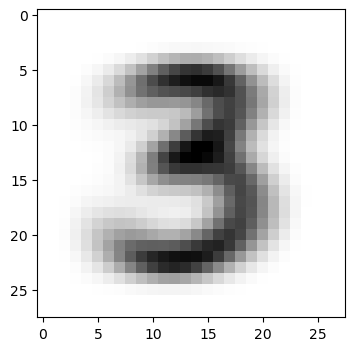

In [13]:
X_three_mean = np.mean(X_threes,axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_three.reshape(28,28),cmap='gray_r')
plt.show()

Run the following code to first create a new data matrix that centers the data by subtracting the mean image, and then visualise some of the images and compare to the original data. Note: you will need to replace `X_three_mean` with the name you gave the mean image in the computation above.

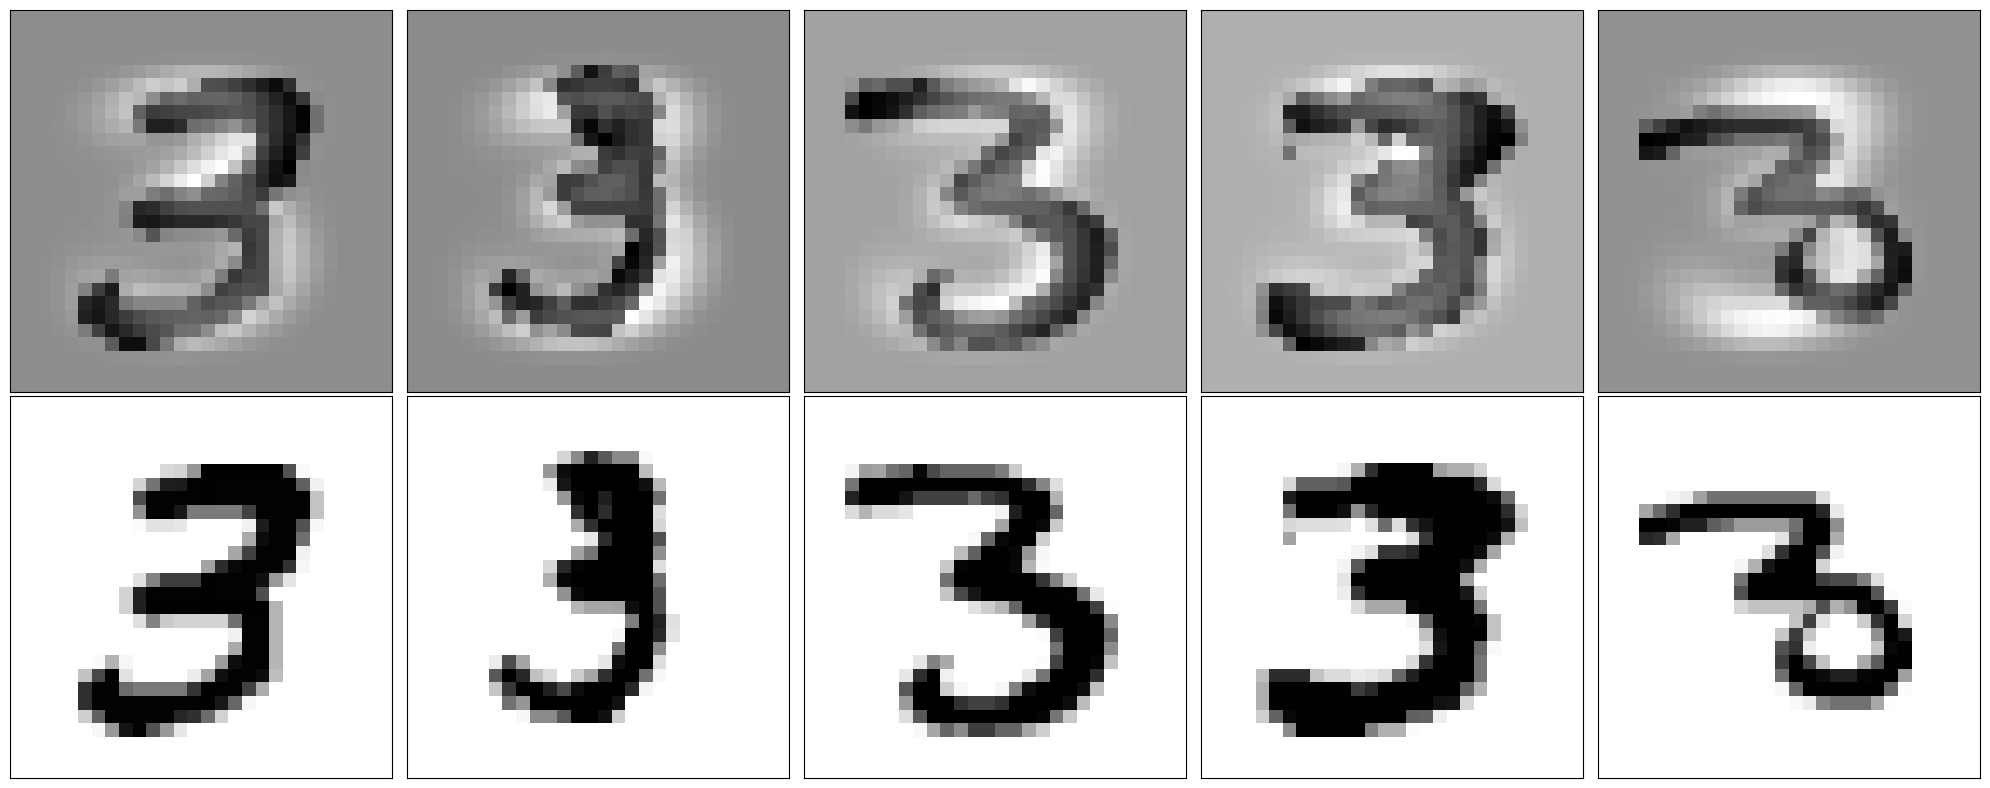

In [14]:
X_three_centred = X_threes - X_three_mean

n_images = 5

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_three_centred[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow(X_threes[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 5 (CORE)

Comment on whether or not the images need to be standardized before using PCA

not need to be standardized because all images are measured on the same scale.

🏁 **Now, is a good point to switch driver and navigator**

# PCA <a id='pca'></a>

Now, we will perform PCA to summarize the main patterns in the images. We will use the [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transformer from the `sklearn.decomposition` package:

- As we saw last week, we start by creating our transformer object, specifying any parameters as desired. For example, we can specify the number of components with the option `n_components`. If omitted, all components are kept.

- Note that by default the `PCA()` transform centers the variables to have zero mean (but does not scale them). 

- After calling `.fit()`, our fitted object has a number of attributes, including:
    - the mean accessible through the attribute `mean_`.
    - the basis vectors (principal components) accesible through the `components_` attribute.

- There are also a number of methods for the fitted object, including `.transform()` to obtain the low-dimensional representation (or also `fit_transform` combining both together). 

 First, let's create the PCA transformer object and call `.fit()`:

In [16]:
pca_threes = PCA(n_components = 200)
pca_threes.fit(X_threes)

,n_components,200
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


## Examining the Basis Vectors and Scores <a id='basis'></a>

### 🚩 Exercise 6 (EXTRA)
 
Plot the mean image by accessing the `mean_` attribute and check that it is the same as above.

In [ ]:
# Code for your answer here!

### 🚩 Exercise 7 (CORE)

Plot the the first four basis vectors as images by accessing the `components_` attribute. What patterns do they seem describe? 

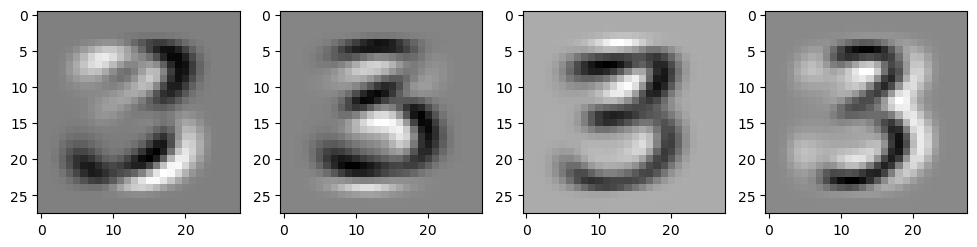

In [18]:
fig, axes = plt.subplots(1,4,figsize=(12,4))
for i in range(4):
    axes[i].imshow(pca_threes.components_[i].reshape(28,28),cmap='gray_r')
plt.show()

The patterns describe the main site where inmages vary from the average: curves, overall shape, top curve's shape, stroke thickness.

### 🚩 Exercise 8 (CORE)

a) Use the `transform()` method to compute the PCA scores and save them in an object called `scores`. Then, plot the data points in the low-dimensional space spanned by the first two principal components. 

In [ ]:
scores = pca_threes.transform(X_threes)
plt.figure(figsize=(4,4))


To better interpret the latent dimensions, let's look at some projected points along each dimension and the corresponding images. Specifically, run the following code to:

- first compute the $5, 25, 50, 75, 95\%$ quantiles of the scores for the first two dimensions
- then find the data point whose projection is closest to each combination of quantiles.

In [ ]:
s1q = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
s2q = np.quantile(scores[:,1],[.05,.25,.5,.75,.95])

idx = np.zeros([len(s1q),len(s2q)])

for i in range(len(s1q)):
    for j in range(len(s2q)):
        aux = ((scores[:,0] - s1q[i])**2 + (scores[:,1] - s2q[j])**2).reshape(N,1)
        idx[i,j] = np.where(aux == min(aux))[0][0]

idx = idx.astype(int)

b) Now, add these points in red to your plot above in.

In [ ]:
# Code for your answer here!

c) Run the following code to plot the images corresponding to this grid of points. Describe the general pattern of the first (left to right) and second (down to up) principal component.

In [ ]:
fig, ax = plt.subplots(len(s1q),len(s2q),figsize=(6,6))
for i in range(len(s1q)):
    for j in range(len(s2q)):
        ax[len(s2q)-1-j,i].imshow(X_threes[idx[i,j],:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

_Type your answer here!_

You can also try to create some artificial images, by fixing different values of the weights. This can also help to interpret the latent dimensions. 

In [ ]:
weight1 = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
weight2 = 0

images_pc1 = np.zeros([len(weight1),D])

count = 0
for w in weight1:   
    images_pc1[count,:] =(pca_threes.mean_ + pca_threes.components_[0,:]*w+pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight1),figsize=(10,6))
for i in range(len(weight1)):
    ax[i].imshow(images_pc1[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 9 (CORE)

Repeat this to describe the third principal component. 

In [ ]:
# Code for your answer here!

_Type your answer here!_

### 🚩 Exercise 10 (EXTRA)

In lecture, we saw that we can also compute the basis vectors from an SVD decomposition of the data matrix. Use the `svd` function in `scipy.linalg` to compute the first three basis vectors and verify that they are the same (up to a change in sign -- note that the signs may be flipped because each principal component specifies a direction in the $D$-dimensional space and flipping the sign has no effect as the direction does not change). 

Does `PCA()` perform principal component analysis using an eigendecomposition of the empirical covariance matrix or using a SVD decomposition of the data matrix?

In [ ]:
# Code for your answer here!
from scipy.linalg import svd


_Type your answer here!_

🏁 **Now, is a good point to switch driver and navigator**

## Selecting the Number of Components <a id='nocomponents'></a>

### 🚩 Exercise 11 (CORE)

Next, let's investigate how many components are needed by considering how much variance is explained by each component.

Note that the `pca_threes` object has an attribute `explained_variance_` (variance of each component) and `explained_variance_ratio_` (proportion of variance explained by each component). 

Plot both the proportion of variance explained and the cummulative proportion of variance explained. Provide a suggestion of how many components to use. How much variance is explained by the suggest number of components? Comment on why we may be able to use this number of components in relation to the total number of features.

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `cumsum()` to compute the cummulative sum of the elements in a vector.
</details>

In [ ]:
# Code for your answer here!

_Type your answer here!_ 

### 🚩 Exercise 12 (CORE)

For your selected number of components, compute the reconstruted images. Plot the reconstruction for a few images and compare with the original images. Comment on the results.  

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `inverse_transform()` to decode the scores.
</details>

In [ ]:
# Code for your answer here!

_Type your answer here!_

🏁 **Now, is a good point to switch driver and navigator**

## Other Digits <a id='other'></a>

Now, let's consider another digit. 

### 🚩 Exercise 13 (CORE)

Perform PCA for another choice of digit. What do the first two components describe? Do some digits have better approximations than others? Comment on why this may be.

In [ ]:
# Cpde for your answer here!

_Type your answer here!_

### Exercise 14 (EXTRA)

Finally, consider now two digits of your choice (edit the code below if you wish to pick different digits).


In [ ]:
# Extract data 
X_twodigits = np.concatenate((digits_dict['3'], digits_dict['8']))
N, D = X_twodigits.shape

Run the following code to compute and plot the mean and some of the principle components for this dataset. 

In [ ]:
# Fit PCA
pca_digits = PCA(n_components = 50)
pca_digits.fit(X_twodigits)

In [ ]:
# Plot the mean image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(pca_digits.mean_.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

In [ ]:
# Plot basis vectors
n_plot = 5
fig, ax = plt.subplots(1,5,figsize=(10,4))
for n in range(n_plot):
  ax[n].imshow(pca_digits.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

Plot the projection of the data in the latent space and color the data by the labels. What do you observe?

In [ ]:
# Code for your answer here!

_Type your answer here!_

Try also to generate artificial images and decsribe how images change along the PCs. 

In [ ]:
# Code for your answer here!

_Type your answer here!_

# Kernel PCA <a id='kpca'></a>

Now, let's try using kernel PCA, which is available through sklearn's [`KernelPCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) transformer. As usual we start by creating our object and specifying parameters (see documentation to learn more about the optional parameters). Then, we use the methods `.fit()` and `.transform()` to fit the object and obtain the lower-dimensional representation.

In the code below, we use the radial basis function kernel, with the inverse bandwith parameter `gamma` set to 0.05. Setting, the option `fit_inverse_transform=True` will allow us to reconstruct the images later (and `alpha` is regularization used when inversing the transforming).

_Note:_ we first subsampled the data, as kernel PCA can be slow on large datasets.  

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare data
y_twodigits = y_twodigits.astype(int)
X_twodigits = MinMaxScaler().fit_transform(X_twodigits)

# Subsample the images (for speed)
X_twodigits_subsampled, X_twodigits_test, y_twodigits_subsampled, y_twodigits_test = train_test_split(
    X_twodigits, y_twodigits, stratify=y_twodigits, random_state=0, train_size=500, test_size=100
)

# Define our KPCA and PCA transformers
n_components = 10
kpca = KernelPCA(
    n_components=n_components, kernel="rbf", gamma=0.05, fit_inverse_transform=True, random_state=0, alpha=0.01)

pca = PCA(n_components=n_components)

# Fit and transform the data
scores_kpca = kpca.fit_transform(X_twodigits_subsampled)
scores_pca = pca.fit_transform(X_twodigits_subsampled)

Next, let's plot the images in the space of the first two components for both kernel PCA and standard PCA.

In [ ]:
# Plot the images in the space of the first two components, colored by digit
i, j = 0, 1 #component indicies
yu =  [3,8] 
fig, ax = plt.subplots(1,2,figsize=(10, 5))
for dig in yu:
    ax[0].scatter(scores_kpca[y_twodigits_subsampled==dig,i], 
               scores_kpca[y_twodigits_subsampled==dig,j],
               c = colors[dig],label=dig)
    ax[1].scatter(scores_pca[y_twodigits_subsampled==dig,i], 
               scores_pca[y_twodigits_subsampled==dig,j],
               c = colors[dig],label=dig)
ax[0].legend()
ax[0].set_xlabel('PCA%d' % (i+1))
ax[0].set_ylabel('PCA%d' % (j+1))
ax[0].set_title('Kernel PCA')
ax[1].legend()
ax[1].set_xlabel('PCA%d' % (i+1))
ax[1].set_ylabel('PCA%d' % (j+1))
ax[1].set_title('Standard PCA')
plt.show()

### Image Denoising
Let's add some noise to our test images that weren't used in the fitting. We will then encode the noisy images into the latent space and then reconstruct our images, to see how well both methods are able to denoise the images.

In [ ]:
# Add noise to the test images
np.random.seed(0)
noise = np.random.normal(0, 0.1, X_twodigits_test.shape)
X_twodigits_test_noisy = X_twodigits_test + noise

# Plot some noisy test images
n_images = 5
fig, ax = plt.subplots(2,n_images,figsize=(2*n_images, 4))
for j in range(n_images):
    ax[0,j].imshow(X_twodigits_test[j].reshape((28,28)), cmap='gray_r')
    ax[1,j].imshow(X_twodigits_test_noisy[j].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
# Add titles
ax[0,2].set_title('Original Images')
ax[1,2].set_title('Noisy Images')
fig.tight_layout()

In [ ]:
# Now transform the noisy test images using both PCA and KernelPCA
scores_kpca_test = kpca.transform(X_twodigits_test_noisy)
scores_pca_test = pca.transform(X_twodigits_test_noisy)

# And reconstruct the noisy test images using both PCA and KernelPCA
X_reconstructed_kpca = kpca.inverse_transform(
    scores_kpca_test)
X_reconstructed_pca = pca.inverse_transform(
    scores_pca_test)

# Plot some reconstructed images
n_images = 5
fig, ax = plt.subplots(4,n_images,figsize=(2*n_images, 8))
for j in range(n_images):
    ax[0,j].imshow(X_twodigits_test[j].reshape((28,28)), cmap='gray_r')
    ax[1,j].imshow(X_twodigits_test_noisy[j].reshape((28,28)), cmap='gray_r')
    ax[2,j].imshow(X_reconstructed_kpca[j].reshape((28,28)), cmap='gray_r')
    ax[3,j].imshow(X_reconstructed_pca[j].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
# Add titles
ax[0,2].set_title('Original Images')
ax[1,2].set_title('Noisy Images')
ax[2,2].set_title('Reconstructed Images (Kernel PCA)')
ax[3,2].set_title('Reconstructed Images (Standard PCA)')
fig.tight_layout()

### Exercise 15 (EXTRA)

a) Try changing the `gamma`. What happens when you increase, e.g. `gamma=0.1`? Or decrease `gamma=0.01`? 

b) Try changing the number of components. How does this affect the reconstructed images for both PCA and kernel PCA?

c) Which method would you prefer for this dataset?


_Type your answer here!_

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please **change 'Student 1' and 'Student 2' at the top of the notebook to include your name(s)**. 

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [ ]:
!jupyter nbconvert --to pdf mlp_week02_key.ipynb 

# Week 2: Principal Component Analysis

**Student Name 1, Student Name 2** 

In this workshop, we will work through a set of problems on dimensionality reduction -- a cannonical form of unsupervised learning. Within the machine learning pipeline, dimensionality reduction is an important tool, which can used in EDA to understand patterns in the data, feature engineering to create a low-dimensional representation of the inputs, and/or in the final phase when you are presenting and visualizing your solution.

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 

## Outline

1. [Problem Definition and Setup](#setup)

2. [Principal Component Analysis](#pca)

    a. [Examining the Basis Vectors and Scores](#basis)

    b. [Selecting the Number of Components](#nocomponents)

    c. [Other Digits](#other)

3. [Kernel PCA](#kpca)

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, lets load in some packages to get us started. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data

Our dataset will be the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which we will download from sklearn. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and focus on the images themselves. Specifically, we will use dimensionality reduction to explore the images and underlying patterns and find a low-dimensional representation.

First, load the data:

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',parser = 'auto')
X = mnist.data
y = mnist.target

### 🚩 Exercise 1 (CORE)

What is stored in `X` and `y` in the command above? What is the shape/datatype etc if an array?


In [11]:
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(70000, 784)
(70000,)


X stored a dateframe, y store a series. the shape of X is (70000,784), the shape of y is (70000,).

Now, let's create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [4]:
digits_dict = {}
X_= X.values
count = 0

for label in y:
  if label in digits_dict:
    digits_dict[label] += [X_[count]]
  else:
    digits_dict[label] = [X_[count]]
  count += 1

Next let's visualize some of the images. We will start by picking a label and plotting a few images from within the dictionary. Note that each image contains a total of 784 pixels (28 by 28) and we will need to `reshape` the image to plot with `imshow(...,cmap='gray_r')`. Try also changing the label to view different digits.

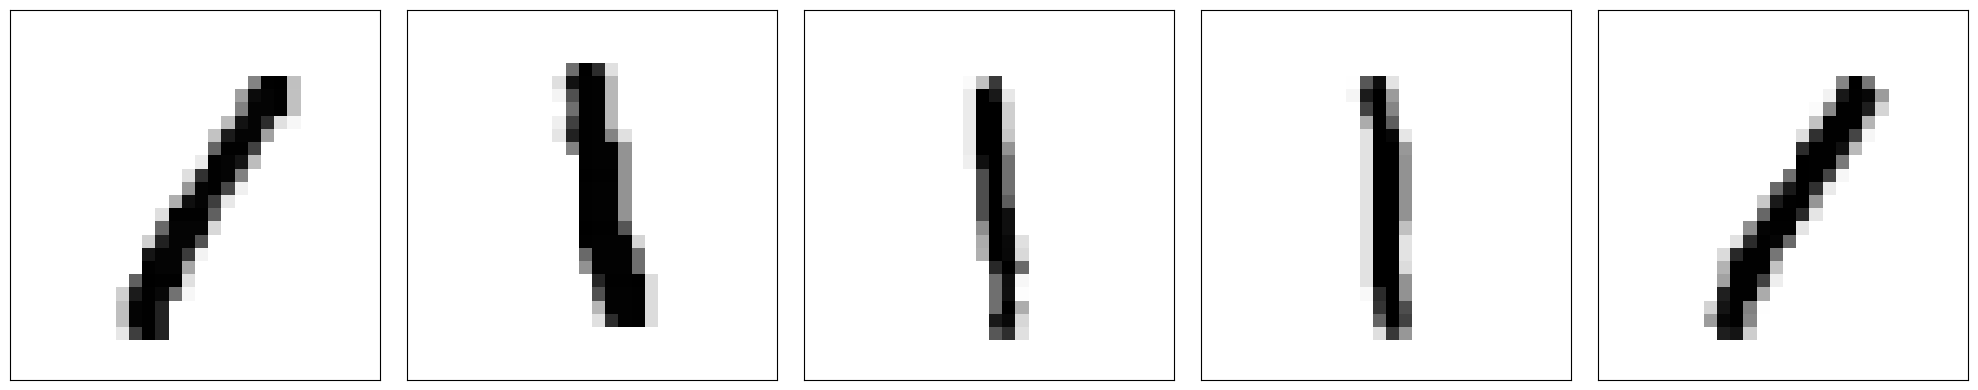

In [4]:
mylabel = '1'
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4))
for j in range(n_images_per_label):
    ax_number = 1 + j
    ax = fig.add_subplot(1, n_images_per_label, ax_number)
    ax.imshow(digits_dict[mylabel][j].reshape((28,28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 2 (EXTRA)

Edit the code above to plot a few images for multiple labels.

<br>
<details><summary><b><u>Hint</b></u></summary>

Create a vector of labels and add additional for loop in the code above.
</details>

In [ ]:
# Code for your answer here!

### 🚩 Exercise 3 (CORE)

Now focus on the 3s only and create a data matrix called `X_threes`. Define also `N` (# datapoints) and `D` (# features).

What are the features in this problem? How many features and data points are there? 

In [10]:
X_threes=np.array(digits_dict['3'])
N = len(X_three)
D = X_three.shape[1]
print(N,D)
print(X_three.shape)

7141 784
(7141, 784)


There are 7141 datapoints and 748 features. features is pixel intensities.

### 🚩 Exercise 4 (CORE)

Now compute and plot the mean image of three.

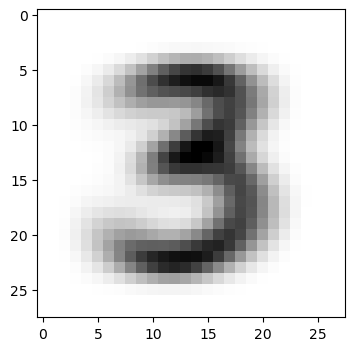

In [13]:
X_three_mean = np.mean(X_threes,axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_three.reshape(28,28),cmap='gray_r')
plt.show()

Run the following code to first create a new data matrix that centers the data by subtracting the mean image, and then visualise some of the images and compare to the original data. Note: you will need to replace `X_three_mean` with the name you gave the mean image in the computation above.

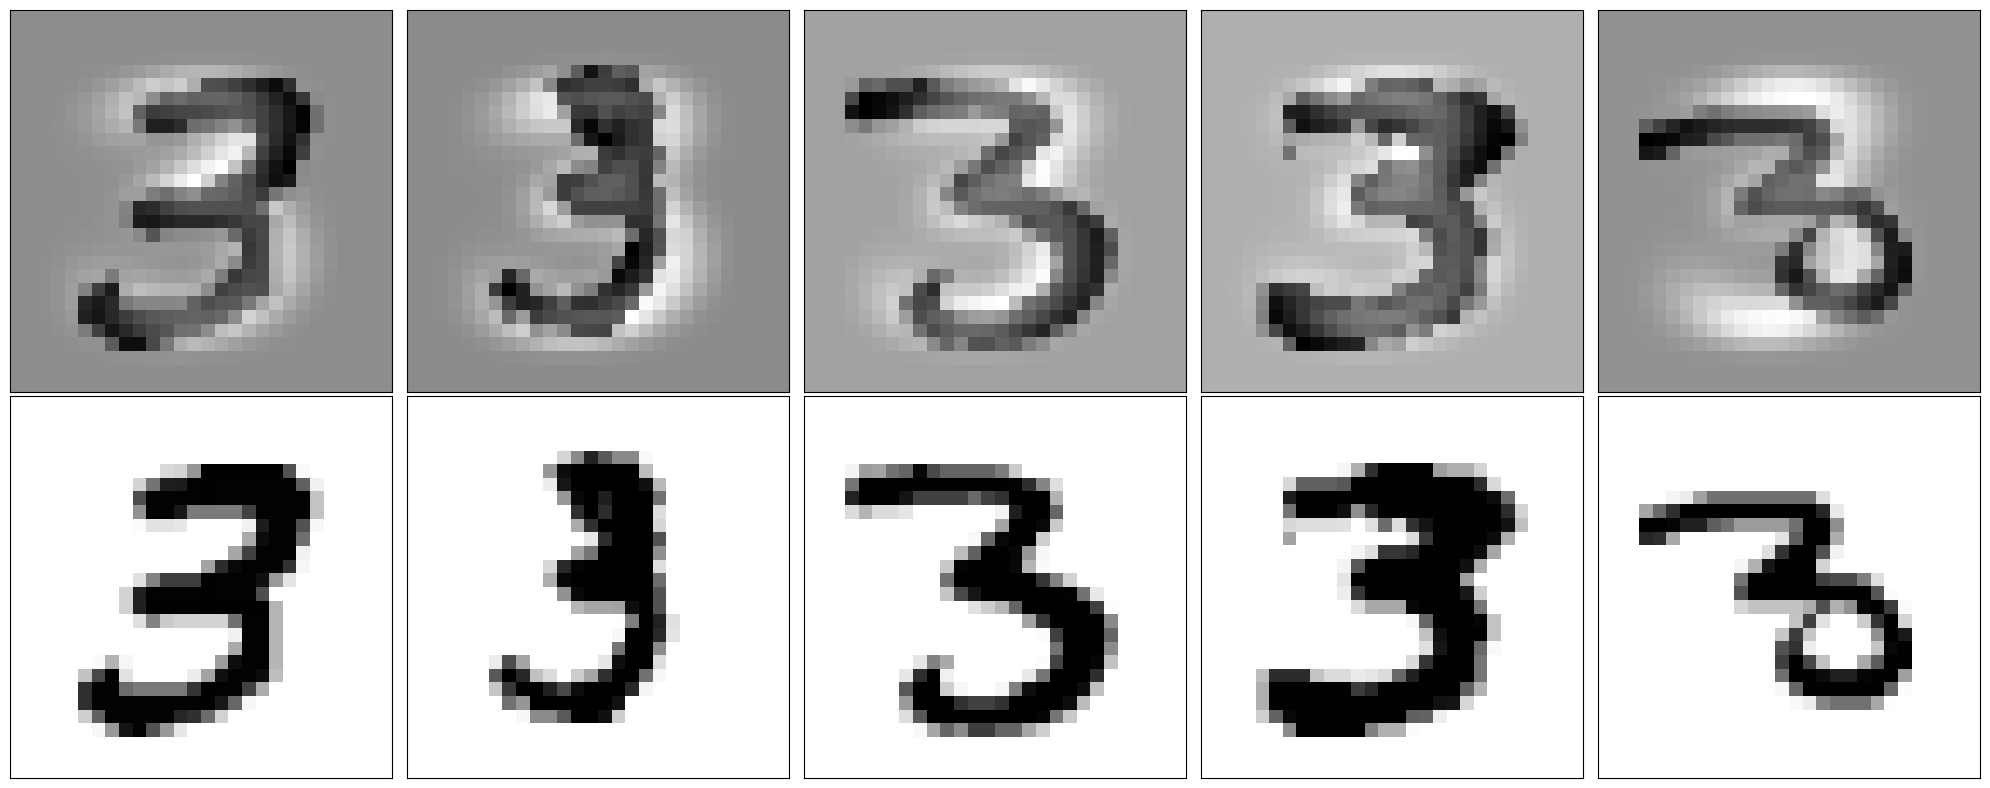

In [14]:
X_three_centred = X_threes - X_three_mean

n_images = 5

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_three_centred[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow(X_threes[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 5 (CORE)

Comment on whether or not the images need to be standardized before using PCA

not need to be standardized because all images are measured on the same scale.

🏁 **Now, is a good point to switch driver and navigator**

# PCA <a id='pca'></a>

Now, we will perform PCA to summarize the main patterns in the images. We will use the [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transformer from the `sklearn.decomposition` package:

- As we saw last week, we start by creating our transformer object, specifying any parameters as desired. For example, we can specify the number of components with the option `n_components`. If omitted, all components are kept.

- Note that by default the `PCA()` transform centers the variables to have zero mean (but does not scale them). 

- After calling `.fit()`, our fitted object has a number of attributes, including:
    - the mean accessible through the attribute `mean_`.
    - the basis vectors (principal components) accesible through the `components_` attribute.

- There are also a number of methods for the fitted object, including `.transform()` to obtain the low-dimensional representation (or also `fit_transform` combining both together). 

 First, let's create the PCA transformer object and call `.fit()`:

In [16]:
pca_threes = PCA(n_components = 200)
pca_threes.fit(X_threes)

,n_components,200
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


## Examining the Basis Vectors and Scores <a id='basis'></a>

### 🚩 Exercise 6 (EXTRA)
 
Plot the mean image by accessing the `mean_` attribute and check that it is the same as above.

In [ ]:
# Code for your answer here!

### 🚩 Exercise 7 (CORE)

Plot the the first four basis vectors as images by accessing the `components_` attribute. What patterns do they seem describe? 

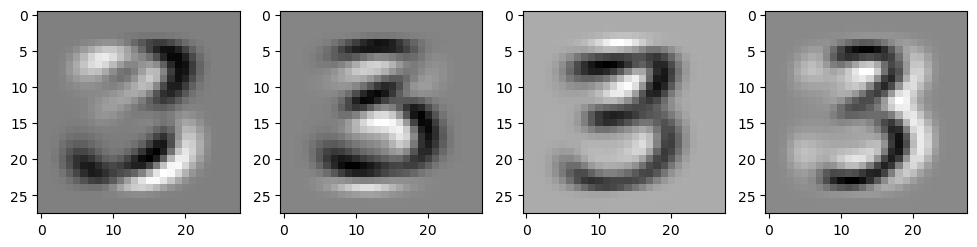

In [18]:
fig, axes = plt.subplots(1,4,figsize=(12,4))
for i in range(4):
    axes[i].imshow(pca_threes.components_[i].reshape(28,28),cmap='gray_r')
plt.show()

The patterns describe the main site where inmages vary from the average: curves, overall shape, top curve's shape, stroke thickness.

### 🚩 Exercise 8 (CORE)

a) Use the `transform()` method to compute the PCA scores and save them in an object called `scores`. Then, plot the data points in the low-dimensional space spanned by the first two principal components. 

In [ ]:
scores = pca_threes.transform(X_threes)
plt.figure(figsize=(4,4))
plt.scatter

To better interpret the latent dimensions, let's look at some projected points along each dimension and the corresponding images. Specifically, run the following code to:

- first compute the $5, 25, 50, 75, 95\%$ quantiles of the scores for the first two dimensions
- then find the data point whose projection is closest to each combination of quantiles.

In [ ]:
s1q = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
s2q = np.quantile(scores[:,1],[.05,.25,.5,.75,.95])

idx = np.zeros([len(s1q),len(s2q)])

for i in range(len(s1q)):
    for j in range(len(s2q)):
        aux = ((scores[:,0] - s1q[i])**2 + (scores[:,1] - s2q[j])**2).reshape(N,1)
        idx[i,j] = np.where(aux == min(aux))[0][0]

idx = idx.astype(int)

b) Now, add these points in red to your plot above in.

In [ ]:
# Code for your answer here!

c) Run the following code to plot the images corresponding to this grid of points. Describe the general pattern of the first (left to right) and second (down to up) principal component.

In [ ]:
fig, ax = plt.subplots(len(s1q),len(s2q),figsize=(6,6))
for i in range(len(s1q)):
    for j in range(len(s2q)):
        ax[len(s2q)-1-j,i].imshow(X_threes[idx[i,j],:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

_Type your answer here!_

You can also try to create some artificial images, by fixing different values of the weights. This can also help to interpret the latent dimensions. 

In [ ]:
weight1 = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
weight2 = 0

images_pc1 = np.zeros([len(weight1),D])

count = 0
for w in weight1:   
    images_pc1[count,:] =(pca_threes.mean_ + pca_threes.components_[0,:]*w+pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight1),figsize=(10,6))
for i in range(len(weight1)):
    ax[i].imshow(images_pc1[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 9 (CORE)

Repeat this to describe the third principal component. 

In [ ]:
# Code for your answer here!

_Type your answer here!_

### 🚩 Exercise 10 (EXTRA)

In lecture, we saw that we can also compute the basis vectors from an SVD decomposition of the data matrix. Use the `svd` function in `scipy.linalg` to compute the first three basis vectors and verify that they are the same (up to a change in sign -- note that the signs may be flipped because each principal component specifies a direction in the $D$-dimensional space and flipping the sign has no effect as the direction does not change). 

Does `PCA()` perform principal component analysis using an eigendecomposition of the empirical covariance matrix or using a SVD decomposition of the data matrix?

In [ ]:
# Code for your answer here!
from scipy.linalg import svd


_Type your answer here!_

🏁 **Now, is a good point to switch driver and navigator**

## Selecting the Number of Components <a id='nocomponents'></a>

### 🚩 Exercise 11 (CORE)

Next, let's investigate how many components are needed by considering how much variance is explained by each component.

Note that the `pca_threes` object has an attribute `explained_variance_` (variance of each component) and `explained_variance_ratio_` (proportion of variance explained by each component). 

Plot both the proportion of variance explained and the cummulative proportion of variance explained. Provide a suggestion of how many components to use. How much variance is explained by the suggest number of components? Comment on why we may be able to use this number of components in relation to the total number of features.

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `cumsum()` to compute the cummulative sum of the elements in a vector.
</details>

In [ ]:
# Code for your answer here!

_Type your answer here!_ 

### 🚩 Exercise 12 (CORE)

For your selected number of components, compute the reconstruted images. Plot the reconstruction for a few images and compare with the original images. Comment on the results.  

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `inverse_transform()` to decode the scores.
</details>

In [ ]:
# Code for your answer here!

_Type your answer here!_

🏁 **Now, is a good point to switch driver and navigator**

## Other Digits <a id='other'></a>

Now, let's consider another digit. 

### 🚩 Exercise 13 (CORE)

Perform PCA for another choice of digit. What do the first two components describe? Do some digits have better approximations than others? Comment on why this may be.

In [ ]:
# Cpde for your answer here!

_Type your answer here!_

### Exercise 14 (EXTRA)

Finally, consider now two digits of your choice (edit the code below if you wish to pick different digits).


In [ ]:
# Extract data 
X_twodigits = np.concatenate((digits_dict['3'], digits_dict['8']))
N, D = X_twodigits.shape

Run the following code to compute and plot the mean and some of the principle components for this dataset. 

In [ ]:
# Fit PCA
pca_digits = PCA(n_components = 50)
pca_digits.fit(X_twodigits)

In [ ]:
# Plot the mean image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(pca_digits.mean_.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

In [ ]:
# Plot basis vectors
n_plot = 5
fig, ax = plt.subplots(1,5,figsize=(10,4))
for n in range(n_plot):
  ax[n].imshow(pca_digits.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

Plot the projection of the data in the latent space and color the data by the labels. What do you observe?

In [ ]:
# Code for your answer here!

_Type your answer here!_

Try also to generate artificial images and decsribe how images change along the PCs. 

In [ ]:
# Code for your answer here!

_Type your answer here!_

# Kernel PCA <a id='kpca'></a>

Now, let's try using kernel PCA, which is available through sklearn's [`KernelPCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) transformer. As usual we start by creating our object and specifying parameters (see documentation to learn more about the optional parameters). Then, we use the methods `.fit()` and `.transform()` to fit the object and obtain the lower-dimensional representation.

In the code below, we use the radial basis function kernel, with the inverse bandwith parameter `gamma` set to 0.05. Setting, the option `fit_inverse_transform=True` will allow us to reconstruct the images later (and `alpha` is regularization used when inversing the transforming).

_Note:_ we first subsampled the data, as kernel PCA can be slow on large datasets.  

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare data
y_twodigits = y_twodigits.astype(int)
X_twodigits = MinMaxScaler().fit_transform(X_twodigits)

# Subsample the images (for speed)
X_twodigits_subsampled, X_twodigits_test, y_twodigits_subsampled, y_twodigits_test = train_test_split(
    X_twodigits, y_twodigits, stratify=y_twodigits, random_state=0, train_size=500, test_size=100
)

# Define our KPCA and PCA transformers
n_components = 10
kpca = KernelPCA(
    n_components=n_components, kernel="rbf", gamma=0.05, fit_inverse_transform=True, random_state=0, alpha=0.01)

pca = PCA(n_components=n_components)

# Fit and transform the data
scores_kpca = kpca.fit_transform(X_twodigits_subsampled)
scores_pca = pca.fit_transform(X_twodigits_subsampled)

Next, let's plot the images in the space of the first two components for both kernel PCA and standard PCA.

In [ ]:
# Plot the images in the space of the first two components, colored by digit
i, j = 0, 1 #component indicies
yu =  [3,8] 
fig, ax = plt.subplots(1,2,figsize=(10, 5))
for dig in yu:
    ax[0].scatter(scores_kpca[y_twodigits_subsampled==dig,i], 
               scores_kpca[y_twodigits_subsampled==dig,j],
               c = colors[dig],label=dig)
    ax[1].scatter(scores_pca[y_twodigits_subsampled==dig,i], 
               scores_pca[y_twodigits_subsampled==dig,j],
               c = colors[dig],label=dig)
ax[0].legend()
ax[0].set_xlabel('PCA%d' % (i+1))
ax[0].set_ylabel('PCA%d' % (j+1))
ax[0].set_title('Kernel PCA')
ax[1].legend()
ax[1].set_xlabel('PCA%d' % (i+1))
ax[1].set_ylabel('PCA%d' % (j+1))
ax[1].set_title('Standard PCA')
plt.show()

### Image Denoising
Let's add some noise to our test images that weren't used in the fitting. We will then encode the noisy images into the latent space and then reconstruct our images, to see how well both methods are able to denoise the images.

In [ ]:
# Add noise to the test images
np.random.seed(0)
noise = np.random.normal(0, 0.1, X_twodigits_test.shape)
X_twodigits_test_noisy = X_twodigits_test + noise

# Plot some noisy test images
n_images = 5
fig, ax = plt.subplots(2,n_images,figsize=(2*n_images, 4))
for j in range(n_images):
    ax[0,j].imshow(X_twodigits_test[j].reshape((28,28)), cmap='gray_r')
    ax[1,j].imshow(X_twodigits_test_noisy[j].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
# Add titles
ax[0,2].set_title('Original Images')
ax[1,2].set_title('Noisy Images')
fig.tight_layout()

In [ ]:
# Now transform the noisy test images using both PCA and KernelPCA
scores_kpca_test = kpca.transform(X_twodigits_test_noisy)
scores_pca_test = pca.transform(X_twodigits_test_noisy)

# And reconstruct the noisy test images using both PCA and KernelPCA
X_reconstructed_kpca = kpca.inverse_transform(
    scores_kpca_test)
X_reconstructed_pca = pca.inverse_transform(
    scores_pca_test)

# Plot some reconstructed images
n_images = 5
fig, ax = plt.subplots(4,n_images,figsize=(2*n_images, 8))
for j in range(n_images):
    ax[0,j].imshow(X_twodigits_test[j].reshape((28,28)), cmap='gray_r')
    ax[1,j].imshow(X_twodigits_test_noisy[j].reshape((28,28)), cmap='gray_r')
    ax[2,j].imshow(X_reconstructed_kpca[j].reshape((28,28)), cmap='gray_r')
    ax[3,j].imshow(X_reconstructed_pca[j].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
# Add titles
ax[0,2].set_title('Original Images')
ax[1,2].set_title('Noisy Images')
ax[2,2].set_title('Reconstructed Images (Kernel PCA)')
ax[3,2].set_title('Reconstructed Images (Standard PCA)')
fig.tight_layout()

### Exercise 15 (EXTRA)

a) Try changing the `gamma`. What happens when you increase, e.g. `gamma=0.1`? Or decrease `gamma=0.01`? 

b) Try changing the number of components. How does this affect the reconstructed images for both PCA and kernel PCA?

c) Which method would you prefer for this dataset?


_Type your answer here!_

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please **change 'Student 1' and 'Student 2' at the top of the notebook to include your name(s)**. 

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [ ]:
!jupyter nbconvert --to pdf mlp_week02_key.ipynb 